In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from pandas.api.types import CategoricalDtype
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *

# stats test
from scipy.stats import f
import scipy.stats as stats
drive_dir = './'

# The helper function
from calculation import *
import sampling

# Additional function

In [99]:
def plot_distribution(df_black,df_white,ele):
    minority_feature = df_black[ele]
    match_feature = df_white[ele]
    bins=np.histogram(np.hstack([minority_feature,match_feature]), bins=15)[1]
    plt.figure(figsize=(8,6))
    plt.hist(minority_feature,bins = bins,weights=np.ones(len(minority_feature)) / len(minority_feature)*100,alpha=0.5,label="Black")
    plt.hist(match_feature,bins = bins,weights=np.ones(len(match_feature)) / len(match_feature)*100,alpha=0.5,label="White")
    plt.xlabel("%s"%(ele), size=14)
    plt.ylabel("Percentage", size=14)
    plt.title("%s Distribution of Black and white"%(ele))
    plt.legend(loc='center right')

In [100]:
def plot_difference_dist(df_black,df_white,ele):
    minority_feature = df_black[ele]
    match_feature = df_white[ele]
    difference = minority_feature.to_numpy() - match_feature.to_numpy()
    bins=np.histogram(np.hstack([minority_feature,match_feature]), bins=15)[1]
    plt.figure(figsize=(8,6))
    plt.hist(difference,weights=np.ones(len(difference)) / len(difference)*100,alpha=0.5)
    plt.xlabel("%s"%(ele), size=14)
    plt.ylabel("Percentage", size=14)
    plt.title("%s difference Distribution of Black and white"%(ele))

# Pipeline

In [21]:
df_whole = pd.read_csv("whole_population.csv")
df_whole = df_whole.drop(['Unnamed: 0'],axis=1)

In [5]:
"""
Normalize the feature values before training the propensity score model

""" 

df_white_black_selected_mean = df_whole.mean()
df_white_black_selected_std = df_whole.std()

for name in df_whole.columns[1:-1]:
    new_name = name + "_nor"
    df_whole[new_name] = \
        df_whole.apply(lambda x: ((x[name]- df_white_black_selected_mean[name])/df_white_black_selected_std[name]),axis=1)
    

In [6]:
#The features we need in later

keep_columns = ['subject_id','rrt_nor', 'gcs_nor', 'sofa_24hours_nor',
       'heart_rate_nor', 'sbp_art_nor', 'dbp_art_nor', 'mbp_cuff_nor',
       'resp_rate_nor', 'temperature_nor', 'spo2_nor', 'glucose_nor',
       'gender_nor', 'admission_age_nor', 'charlson_comorbidity_index_nor',
       'apsiii_nor','bmi_nor','race_white_black','ventilation_status']

In [7]:
"""
Propensity score with logistic regression

Since ventilation is the ultimate feature we want to observe, we are not going to include it in our propensity score
model.
"""
psm = \
    PsmPy(df_whole[keep_columns], treatment='race_white_black', indx='subject_id', exclude = ['ventilation_status'])

In [8]:
psm.logistic_ps(balance = False)
# If we apply propensity score directly
psm.knn_matched(matcher='propensity_logit', replacement=False, caliper=None)

In [9]:
df_black_selected = pd.DataFrame()
df_white_selected = pd.DataFrame()

for index,row in psm.matched_ids.iterrows():
    black_id = row['subject_id']
    temp_black = df_whole[df_whole['subject_id'] == black_id]
    df_black_selected = pd.concat([df_black_selected,temp_black])
        
    white_id = row['matched_ID']
    temp_white = df_whole[df_whole['subject_id'] == white_id]
    df_white_selected = pd.concat([df_white_selected,temp_white])

In [10]:
# Take a look at the columns and find out what we are interested in
df_whole.columns

Index(['subject_id', 'ventilation_status', 'rrt', 'gcs', 'sofa_24hours',
       'heart_rate', 'sbp_art', 'dbp_art', 'mbp_cuff', 'resp_rate',
       'temperature', 'spo2', 'glucose', 'gender', 'admission_age',
       'charlson_comorbidity_index', 'apsiii', 'bmi', 'race_white_black',
       'ventilation_status_nor', 'rrt_nor', 'gcs_nor', 'sofa_24hours_nor',
       'heart_rate_nor', 'sbp_art_nor', 'dbp_art_nor', 'mbp_cuff_nor',
       'resp_rate_nor', 'temperature_nor', 'spo2_nor', 'glucose_nor',
       'gender_nor', 'admission_age_nor', 'charlson_comorbidity_index_nor',
       'apsiii_nor', 'bmi_nor'],
      dtype='object')

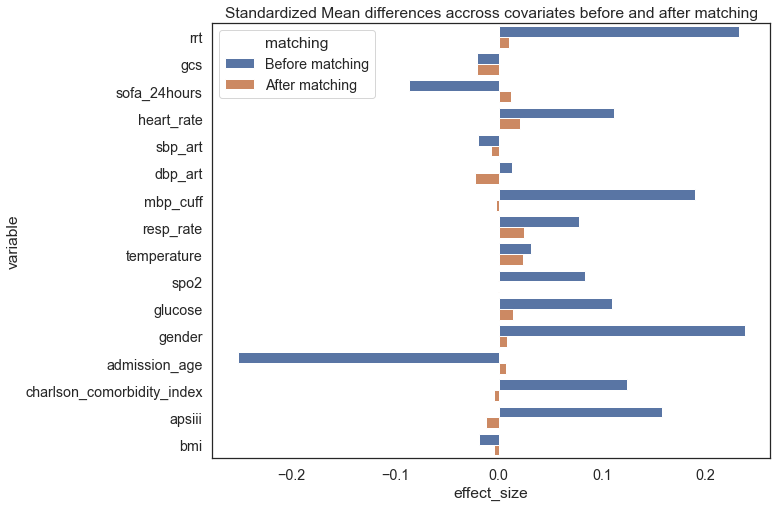

In [11]:
columns_of_interest = df_whole.columns[2:18]
plot_standardized_change(df_whole,df_black_selected,df_white_selected,columns_of_interest,'race_white_black')

In [12]:
res_direct_prop = dp_t_calculation_two_group(df_black_selected,df_white_selected,columns_of_interest)

In [13]:
df_res_diret_prop = pd.DataFrame(res_direct_prop).T
df_res_diret_prop.columns = ['DP_gap','shapiro','paired_t','w_test']
df_res_diret_prop

,DP_gap,shapiro,paired_t,w_test
rrt,[0.00354191263282172],[1.0],[0.738210248418444],[0.7381026926356603]
gcs,[0.03984651711924414],[1.0],[0.5552977344700702],[0.6405298241589275]
sofa_24hours,[0.029515938606847758],[1.0],[0.7194196181388003],[0.3027512295265786]
heart_rate,[0.4367894772484675],[1.0],[0.5327600105611532],[0.3997339888115542]
sbp_art,[0.20029833937489627],[1.0],[0.834796243893739],[0.8728607642698838]
dbp_art,[0.4115835166993591],[1.0],[0.501618710415564],[0.6136170643057657]
mbp_cuff,[0.045605191738630424],[1.0],[0.9403227315043811],[0.9517199421735407]
resp_rate,[0.14635414680425285],[1.0],[0.4717981367710745],[0.4719604897986702]
temperature,[0.017284041715875276],[1.0],[0.4956671703993917],[0.227323471068825]
spo2,[0.000518189995759144],[1.0],[0.9975458327853244],[0.012487456007806784]


# Further processing

In [22]:
df_whole.head()

,subject_id,ventilation_status,rrt,gcs,sofa_24hours,heart_rate,sbp_art,dbp_art,mbp_cuff,resp_rate,temperature,spo2,glucose,gender,admission_age,charlson_comorbidity_index,apsiii,bmi,race_white_black
0,10001884.0,5,0.0,15.0,3.0,38.0,134.000000,75.000000,46.0,18.0,35.40,100.0,144.0,1,77,6,51,26.370238,1
1,10002155.0,1,0.0,15.0,0.0,68.0,115.000000,59.000000,72.0,18.0,36.56,97.0,208.0,1,81,10,37,27.679501,0
2,10002348.0,1,0.0,15.0,0.0,72.0,124.000000,64.000000,85.0,14.0,36.61,93.0,106.0,1,77,10,43,27.679501,0
3,10002443.0,1,0.0,15.0,0.0,106.0,101.000000,56.000000,113.0,12.0,35.94,85.0,110.0,0,53,4,44,49.267769,0
4,10002527.0,0,0.0,15.0,4.0,89.0,126.666667,58.333333,73.0,19.0,36.61,96.0,112.0,0,50,1,35,31.289062,0


In [23]:
"""
1. Append the propensity score to each individuual patients 
2. Calculate the pair-wise difference between any possible pair with one candidate 
    from majority group and the other one from minority group

"""

df_whole = df_whole.merge(psm.predicted_data[['subject_id','propensity_logit']],how='inner',on='subject_id')

df_white = df_whole[df_whole['race_white_black'] == 0].reset_index()
df_black = df_whole[df_whole['race_white_black'] == 1].reset_index()

In [26]:
df_whole

,subject_id,ventilation_status,rrt,gcs,sofa_24hours,heart_rate,sbp_art,dbp_art,mbp_cuff,resp_rate,temperature,spo2,glucose,gender,admission_age,charlson_comorbidity_index,apsiii,bmi,race_white_black,propensity_logit
0,10001884.0,5,0.0,15.0,3.0,38.000000,134.000000,75.000000,46.0,18.0,35.40,100.0,144.0,1,77,6,51,26.370238,1,-2.629947
1,10002155.0,1,0.0,15.0,0.0,68.000000,115.000000,59.000000,72.0,18.0,36.56,97.0,208.0,1,81,10,37,27.679501,0,-1.902475
2,10002348.0,1,0.0,15.0,0.0,72.000000,124.000000,64.000000,85.0,14.0,36.61,93.0,106.0,1,77,10,43,27.679501,0,-1.873227
3,10002443.0,1,0.0,15.0,0.0,106.000000,101.000000,56.000000,113.0,12.0,35.94,85.0,110.0,0,53,4,44,49.267769,0,-2.495681
4,10002527.0,0,0.0,15.0,4.0,89.000000,126.666667,58.333333,73.0,19.0,36.61,96.0,112.0,0,50,1,35,31.289062,0,-2.891405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16104,19997473.0,1,0.0,15.0,2.0,100.000000,107.250000,59.500000,99.0,22.0,36.83,98.0,113.0,1,82,9,41,27.679501,0,-1.873949
16105,19997886.0,0,0.0,14.0,4.0,90.000000,107.250000,59.500000,98.0,22.0,37.17,99.0,149.0,0,72,7,73,27.679501,0,-2.287705
16106,19998591.0,0,0.0,15.0,1.0,98.000000,107.250000,59.500000,69.0,13.0,37.11,99.0,135.0,1,53,4,121,27.679501,0,-1.736657
16107,19999442.0,0,0.0,11.0,3.0,90.333333,155.666667,83.000000,37.0,19.0,36.83,97.0,136.0,0,43,5,28,28.859835,0,-2.416955


In [27]:
all_pair_distance = calculate_all_pair_difference(df_black,df_white,'propensity_logit')

In [28]:
all_pair_distance_lst = []
for individual in all_pair_distance:
    all_pair_distance_lst.append(individual)

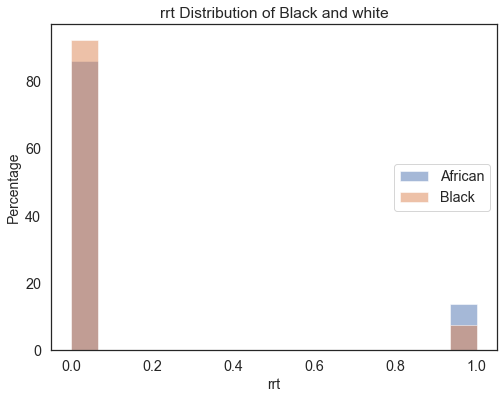

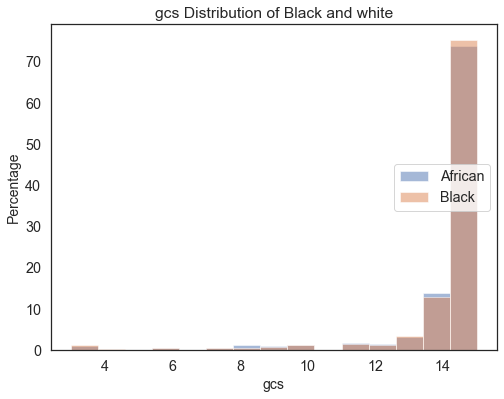

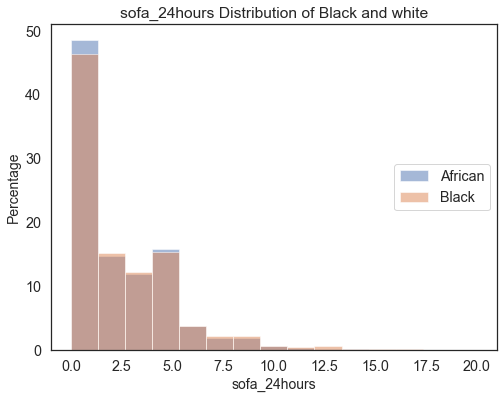

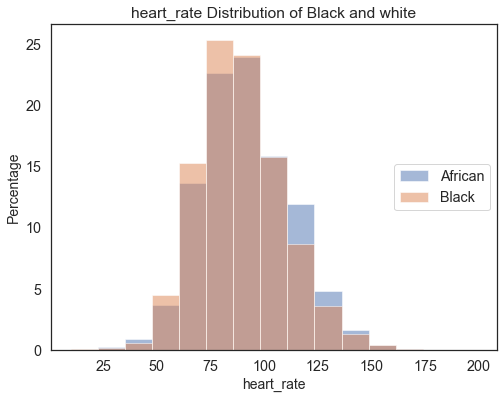

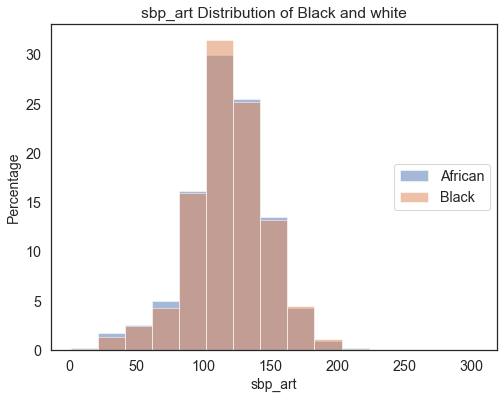

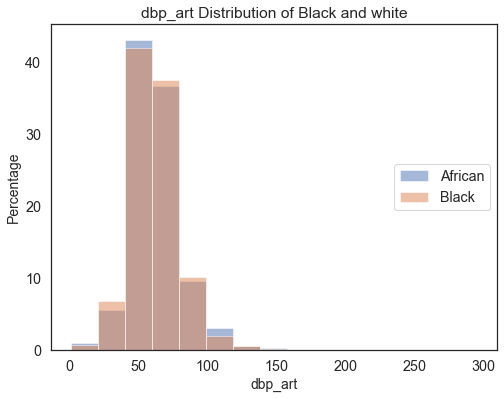

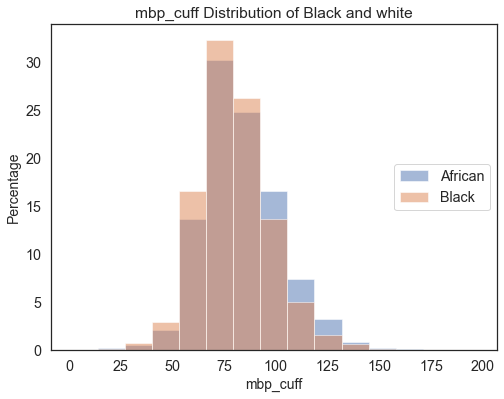

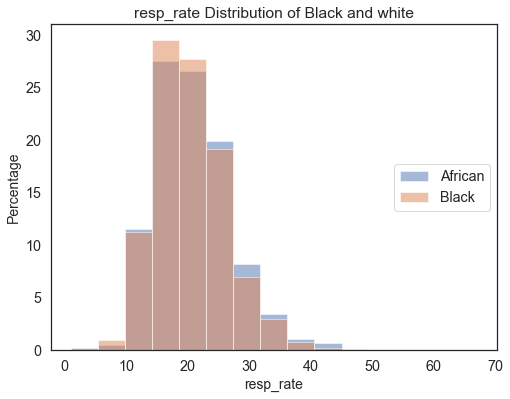

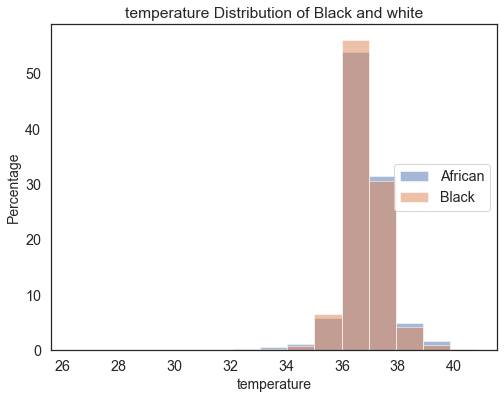

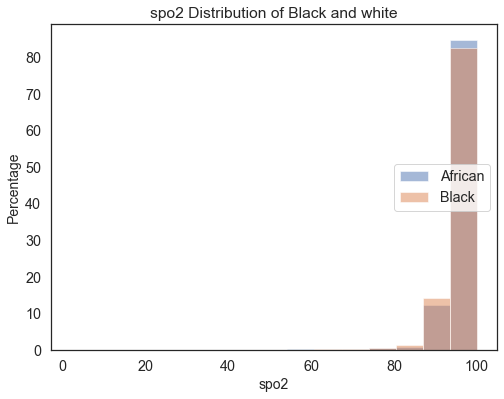

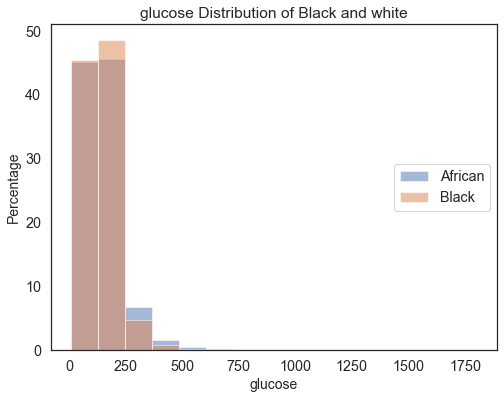

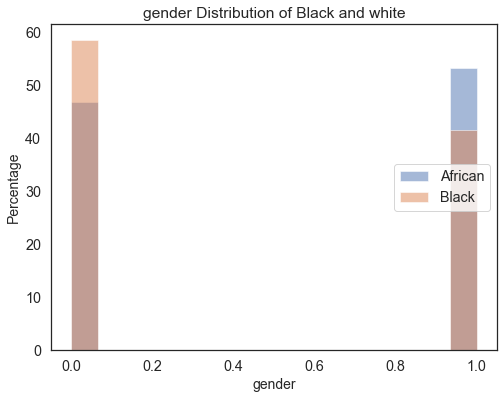

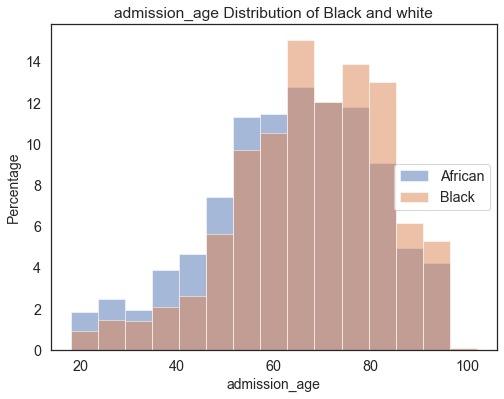

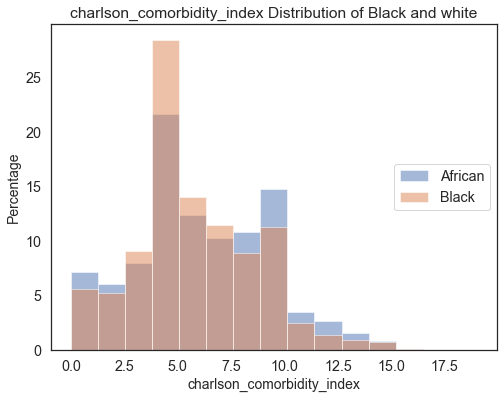

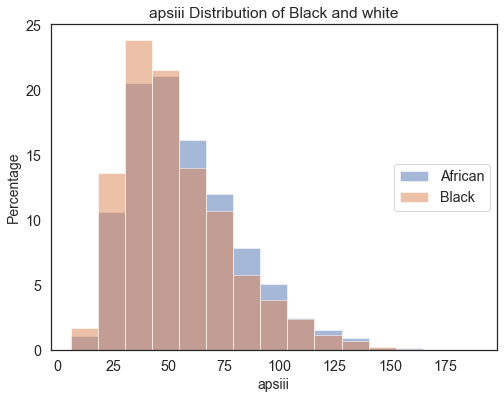

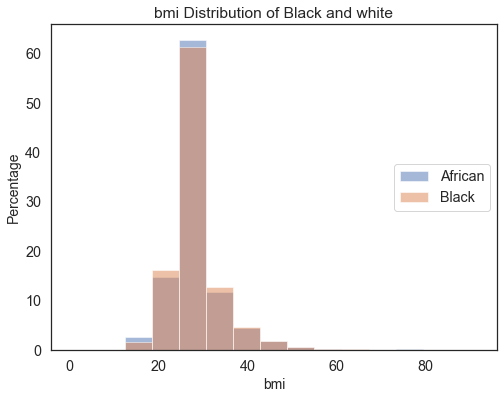

In [31]:
for ele in columns_of_interest:
    plot_distribution(df_black,df_white,ele)

In [59]:
df_whole.std()

subject_id                    2.878810e+06
ventilation_status            1.657441e+00
rrt                           2.734310e-01
gcs                           1.979382e+00
sofa_24hours                  2.586227e+00
heart_rate                    2.010709e+01
sbp_art                       2.900606e+01
dbp_art                       1.832084e+01
mbp_cuff                      1.748655e+01
resp_rate                     5.815391e+00
temperature                   7.355780e-01
spo2                          5.613963e+00
glucose                       6.841991e+01
gender                        4.946435e-01
admission_age                 1.566637e+01
charlson_comorbidity_index    2.889763e+00
apsiii                        2.463792e+01
bmi                           6.075544e+00
race_white_black              3.067672e-01
propensity_logit              5.551811e-01
dtype: float64

# Use p-value = 0.1 as threshold and one standard deviation as demo
### The procedure are similar for other threshold

In [47]:
measure_columns = ['rrt', 'gcs', 'sofa_24hours', 'heart_rate',
       'sbp_art', 'dbp_art', 'mbp_cuff', 'resp_rate', 'temperature', 'spo2',
       'glucose', 'gender', 'admission_age', 'charlson_comorbidity_index',
       'apsiii', 'bmi']

In [48]:
candidate_index_lst_0_1 = filter_with_delta_threshold(all_pair_distance,all_pair_distance_lst,0.1)
qualified_ids_lst_0_1 = filter_with_std(df_whole,df_black,df_white,measure_columns,'subject_id',candidate_index_lst_0_1)

In [49]:
matched_ids_0_1 = pd.DataFrame(columns = ['subject_id','matched_ID'])
for index,row in df_black.iterrows():
    black_score = row['propensity_logit']
    if len(qualified_ids_lst_0_1[index]) > 0:
        subject_id = row['subject_id']
        matched_id = 10000
        min_dist = 100000
        for white_id in qualified_ids_lst_0_1[index]:
            white_score = df_white[df_white['subject_id'] == white_id]['propensity_logit']
            temp_dist = math.sqrt((black_score - white_score)*(black_score - white_score))
            if (temp_dist < min_dist):
                min_dist = temp_dist
                matched_id = white_id
        matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)

/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folde

/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folde

/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folde

/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folde

/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folde

/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folde

/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folde

/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folde

/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folde

/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folde

/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folde

/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folde

/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folde

/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folde

/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folde

/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folde

/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folde

/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folde

/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folders/dt/mdt015dj6z59bp7yc5rmx3500000gn/T/ipykernel_82759/2820316964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matched_ids_0_1 = matched_ids_0_1.append({'subject_id': subject_id, 'matched_ID':matched_id}, ignore_index=True)
/var/folde

In [51]:
df_black_selected_0_1 = pd.DataFrame()
df_white_selected_0_1 = pd.DataFrame()
for index_black, row_black in matched_ids_0_1.iterrows():
    black_id = row_black['subject_id']
    temp_black = df_whole[df_whole['subject_id'] == black_id]
    df_black_selected_0_1 = pd.concat([df_black_selected_0_1,temp_black])
    
    white_id = row_black['matched_ID']
    temp_white = df_whole[df_whole['subject_id'] == white_id]
    df_white_selected_0_1 = pd.concat([df_white_selected_0_1,temp_white])

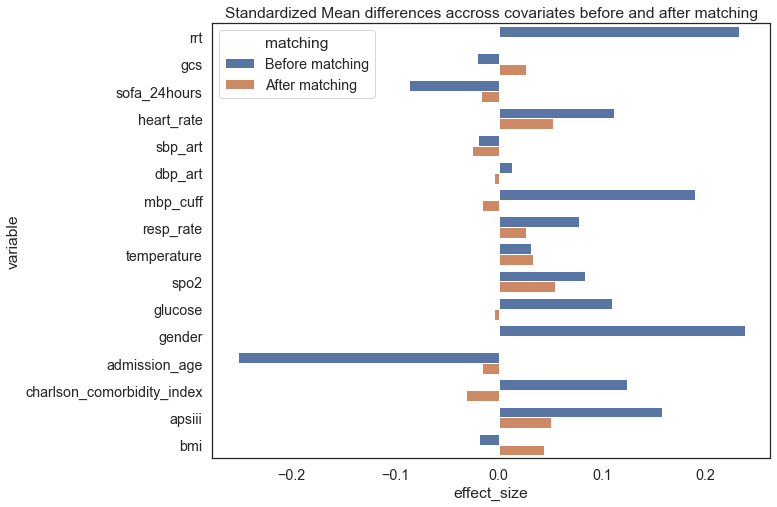

In [52]:
plot_standardized_change(df_whole,df_black_selected_0_1,df_white_selected_0_1,columns_of_interest,'race_white_black')

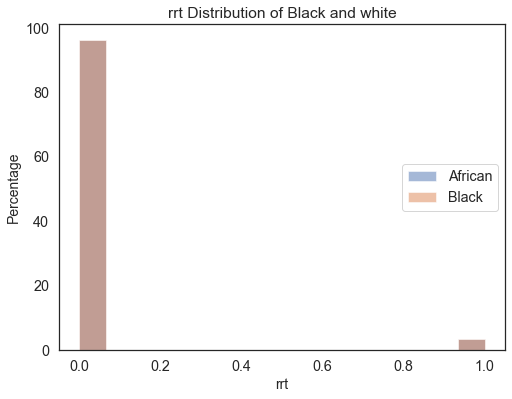

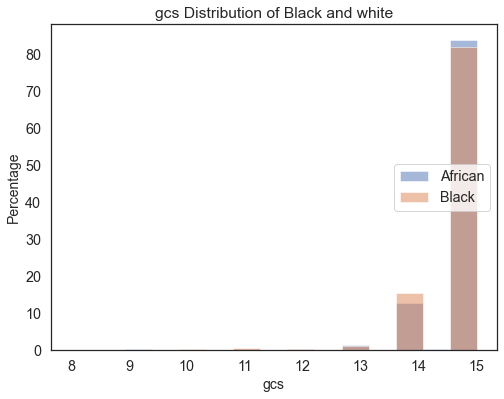

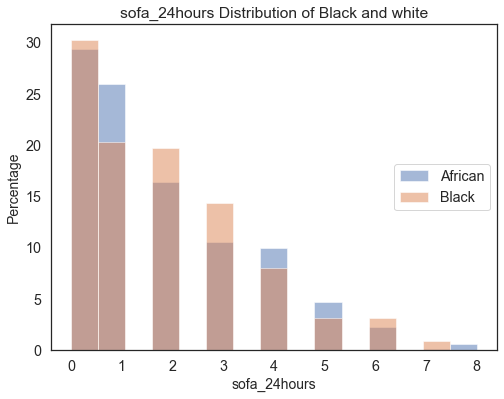

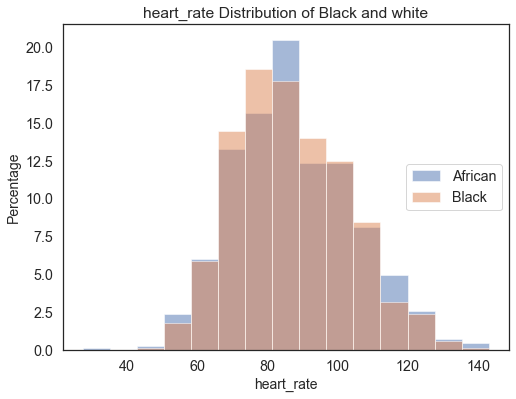

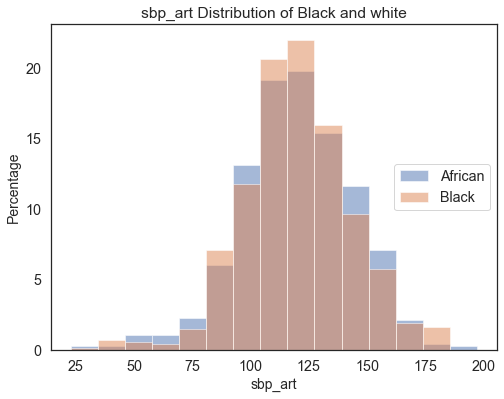

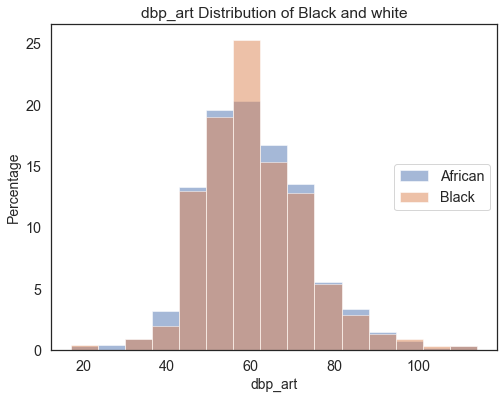

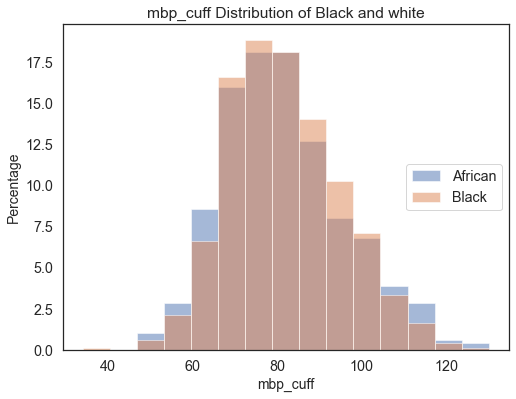

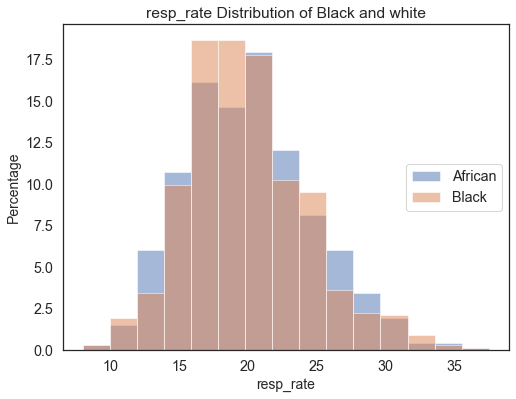

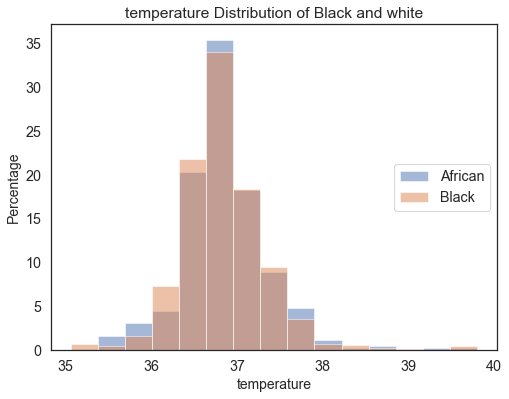

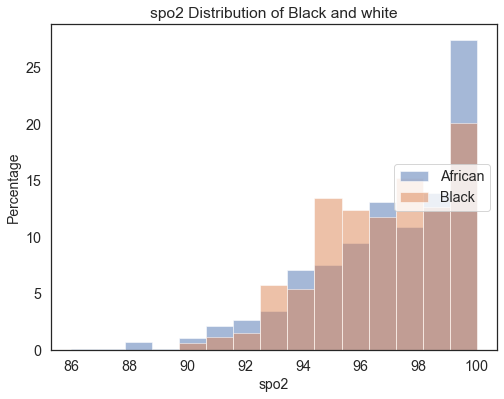

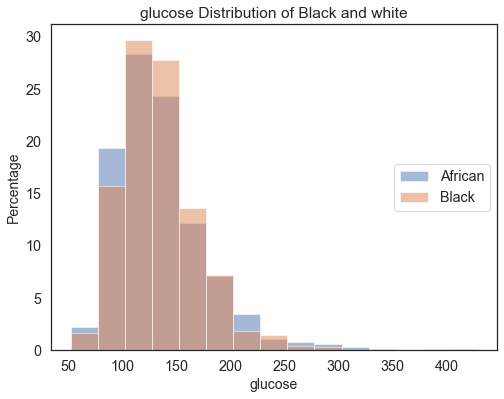

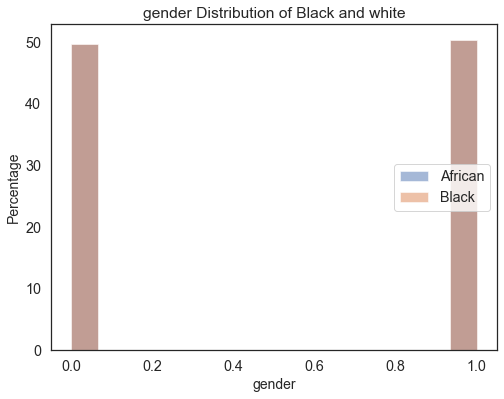

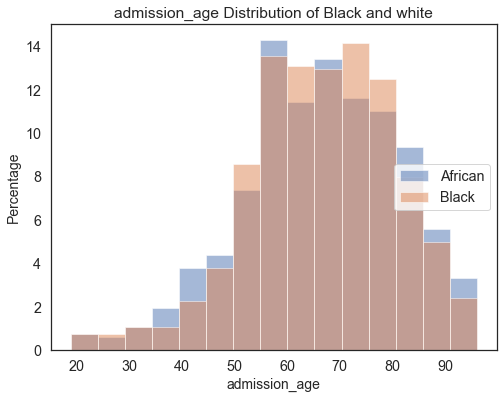

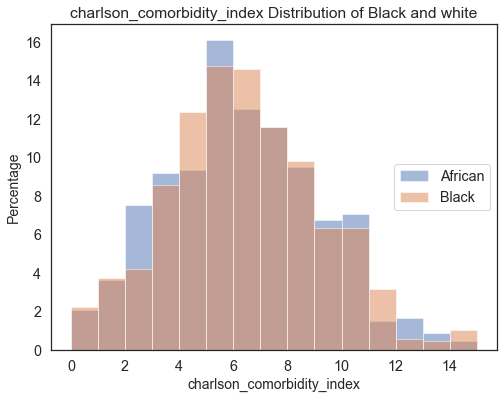

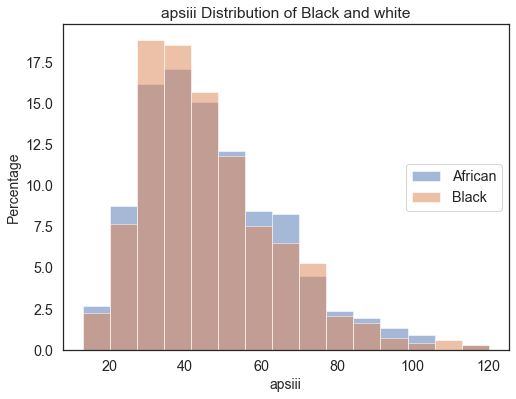

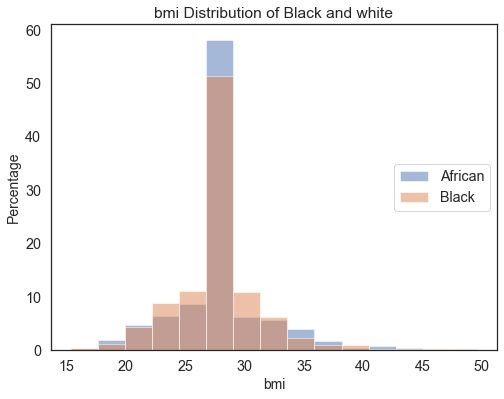

In [53]:
for ele in measure_columns:
    plot_distribution(df_black_selected_0_1,df_white_selected_0_1,ele)

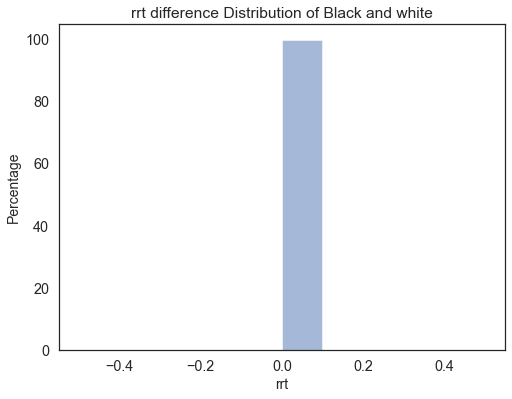

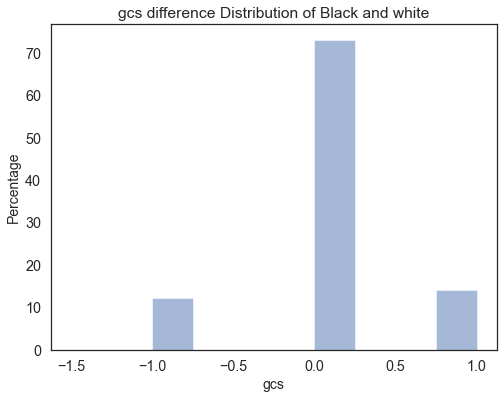

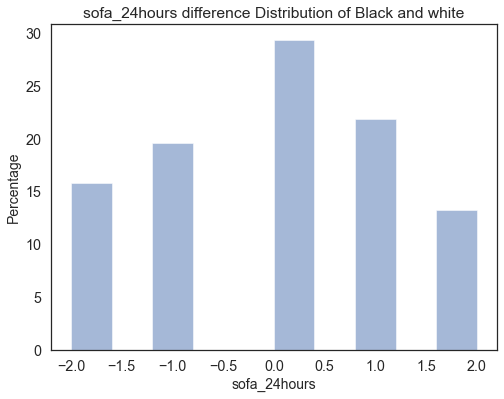

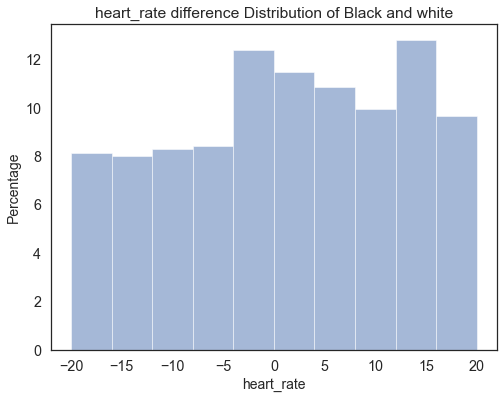

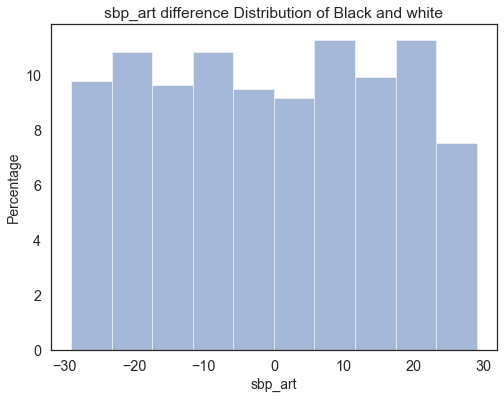

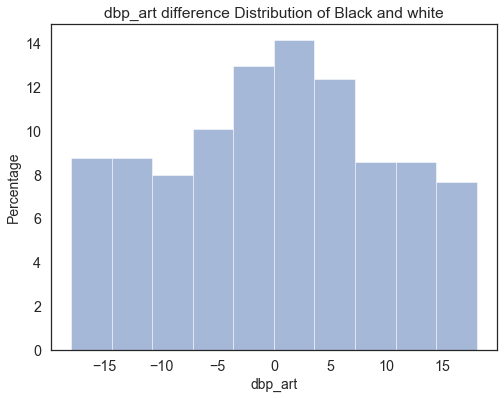

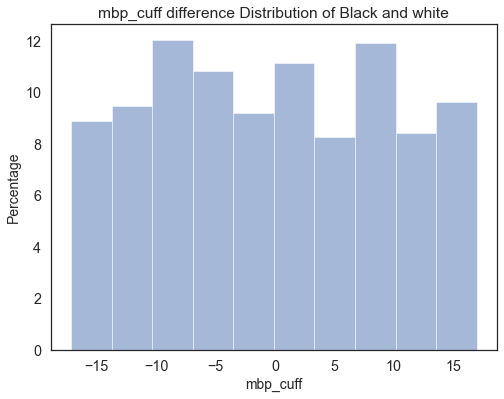

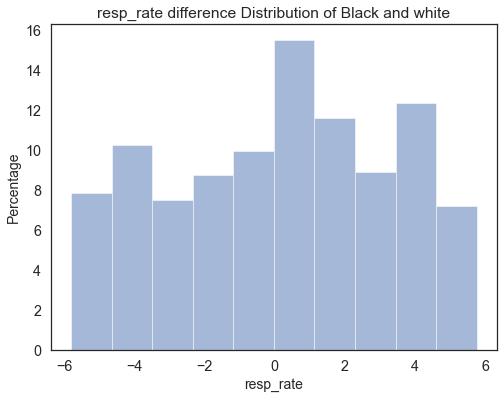

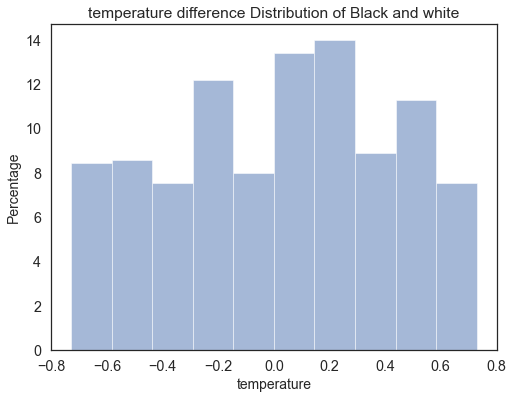

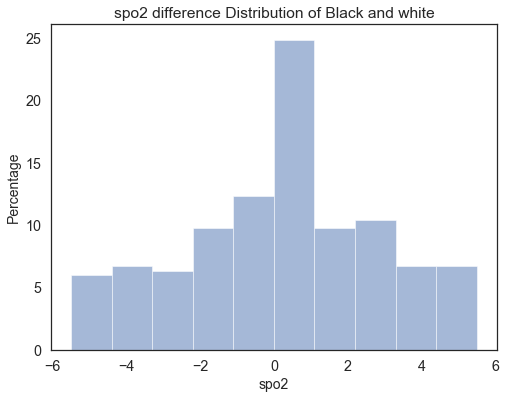

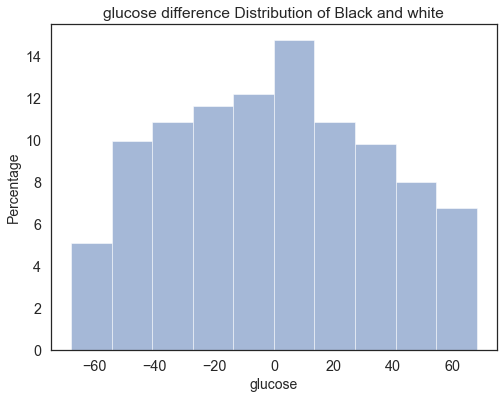

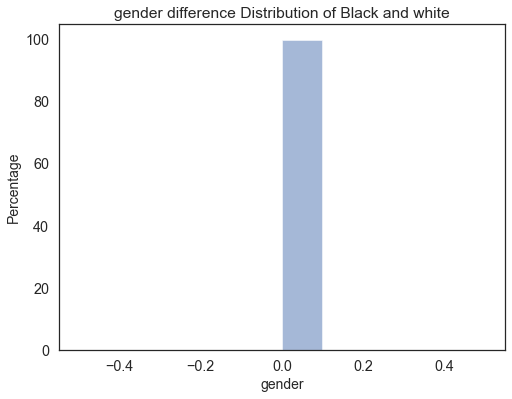

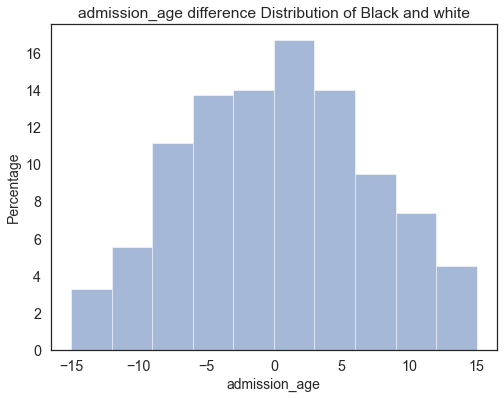

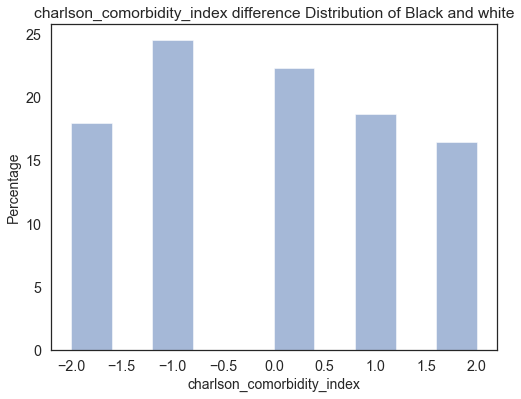

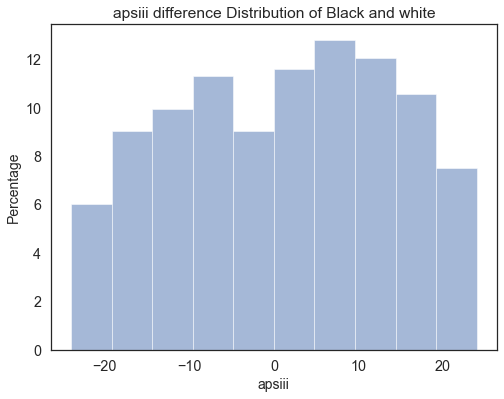

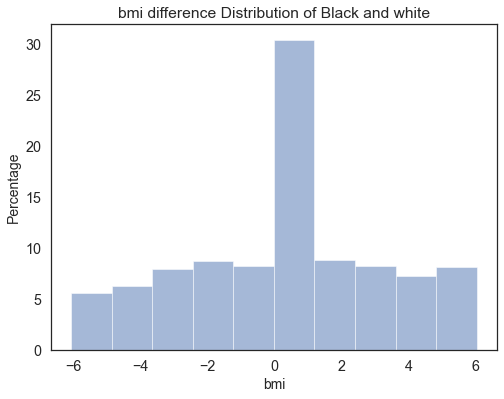

In [58]:
for ele in measure_columns:
    plot_difference_dist(df_black_selected_0_1,df_white_selected_0_1,ele)

## Random sampling

In [92]:
import sampling

In [94]:
import importlib
importlib.reload(sampling)

<module 'sampling' from '/Users/zhengyangzhou/Downloads/capstone_harvard/venv/sampling.py'>

In [103]:
measure_columns_plus = ['rrt',
 'gcs',
 'sofa_24hours',
 'heart_rate',
 'sbp_art',
 'dbp_art',
 'mbp_cuff',
 'resp_rate',
 'temperature',
 'spo2',
 'glucose',
 'gender',
 'admission_age',
 'charlson_comorbidity_index',
 'apsiii',
 'bmi','ventilation_status']

In [104]:
# Random sample for 100 times
res_random_dict = sampling.dp_t_calculation_random(df_black_selected_0_1,df_white,100,measure_columns_plus)

In [105]:
df_res_random = sampling.output_sampling_result(res_random_dict)

In [106]:
df_res_random

,feature,dp_mean,dp_std,p_value_mean,p_value_std
0,rrt,0.037949,0.008367,8.881801e-03,1.848534e-02
1,gcs,0.515528,0.075757,5.950568e-08,3.469185e-07
2,sofa_24hours,0.689683,0.102985,1.798655e-06,9.308612e-06
3,heart_rate,1.462152,0.731163,2.439847e-01,2.506166e-01
4,sbp_art,1.043541,0.772596,5.355831e-01,2.838536e-01
5,dbp_art,1.294730,0.662317,2.290264e-01,2.181272e-01
6,mbp_cuff,1.374737,0.557408,1.911987e-01,2.147805e-01
7,resp_rate,0.500186,0.216370,1.628371e-01,1.899424e-01
8,temperature,0.035915,0.025311,4.107912e-01,3.159521e-01
9,spo2,1.259617,0.179592,2.501503e-06,8.354707e-06


## Stratified Sampling

In [110]:
# Random sample for 100 times
res_stratified_dict = sampling.dp_t_calculation_stratified(df_black_selected_0_1,df_white,100,measure_columns_plus,'ventilation_status')

In [111]:
df_res_stratified = sampling.output_sampling_result(res_stratified_dict)

In [112]:
df_res_stratified

,feature,dp_mean,dp_std,p_value_mean,p_value_std
0,rrt,0.039170,0.009699,9.939759e-03,2.259062e-02
1,gcs,0.516893,0.072909,1.082361e-08,3.373393e-08
2,sofa_24hours,0.720181,0.096110,6.839891e-07,2.950670e-06
3,heart_rate,1.471611,0.736787,2.391552e-01,2.365709e-01
4,sbp_art,1.059602,0.729086,5.218587e-01,2.767514e-01
5,dbp_art,1.204374,0.687978,2.745805e-01,2.653495e-01
6,mbp_cuff,1.575212,0.606882,1.450928e-01,1.937965e-01
7,resp_rate,0.496699,0.234949,1.856130e-01,2.385381e-01
8,temperature,0.034106,0.023726,4.225158e-01,2.891352e-01
9,spo2,1.303935,0.210115,5.159416e-06,2.766311e-05
